# Parameter study on the numerical model

Deflection assumptions for servicability analysis of Pixel.frame

1. Higher strength concrete implies smaller deflection.<br>
**-> Higher fc' pieces can be used**
<br> <br>
2. Maximum deflection for uniform loads or non-mid-beam load are always less than concentrated mid loads.<br>
**-> If concentrated mid load passes the servicability limit, other uniform/non-mid-beam load must also passes.**
<br><br>
*However, the current numerical model requires 2 load points, so it will be 2 points close to the mid-beam (Ls = 0.45L) 2 loads P1 = P2 = P/2.
<br><br>
3. From the paper, number of deviators does not significantly affect the load-deflection curve, except from 0 to 1 (no deviator to 1 or more deviators).<br>
**-> We will stick with 1 midpoint deviator, except for secondary beams, we will use 0 deviator.**

Load required packages 

In [31]:
using Pkg
Pkg.status()
Pkg.instantiate()
# Pkg.update()

Status `~/dev/ExPoBeam/HalfScaleTest/Project.toml`
⌃ [336ed68f] CSV v0.10.11
⌃ [a93c6f00] DataFrames v1.5.0
⌃ [e9467ef8] GLMakie v0.8.5
⌅ [ee78f7c6] Makie v0.19.5
  [3a884ed6] UnPack v1.0.2
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


In [32]:
using CSV, DataFrames
using UnPack
using Makie, GLMakie 

### Include associate files/functions

In [33]:
include("Definition.jl")
include("functions.jl")
include("Interpolations.jl")

get_Icrack

..........Notes.......... <br>
Use Ld = Ls (this test only) <br>
Eccentricities measured from the neutral axis <br>
M is the moment in the constant region <br>
Mg = moment due to the selfweight <br>
M(x) is the moment equation due to the load <br>
Units N, mm, MPa <br>


In [ ]:
#input parameters 

#Varying
fc′ (28-56)
number of deviators (0 1 2 3) 
deviator positions (/3 , /4, )
point load positions (0.2L -> 0.49L)



In [ ]:
set_fc′ = 28.0:1.0:56.0 
n_deviators = [0,1,2,3]
deviators_pos = 0.5:0.1:1.0
p_pos = 0.2:0.05:0.45

In [ ]:
#Inputs
    #..........Notes..........
    # Use Ld = Ls (this test only) 
    # Eccentricities measured from the neutral axis
    # M is the moment in the constant region
    # Mg = moment due to the selfweight
    # M(x) is the moment equation due to the load
    #Units N, mm, MPa

    #   Material Properties
    fc′ = 36.0 # Concrete strength [MPa] ****Should update on the test day using cylinder test***
    # Ec = 4700.0*sqrt(fc′) # MPa  ACI fc-> Concrete modulus relationship [MPa]
    Ec = 58000.0 # MPa  from the cylinder test
    Eps = 70000.0 #Post tensioning steel modulus [MPa]
    fpy = 0.002 * Eps #MPa  
    #Safe load on the website https://www.engineeringtoolbox.com/wire-rope-strength-d_1518.html 
    # is ~ 150 MPa. Currently 140 MPa :)

    # PixelFrame section/element properties
    centroid_to_top = 91.5 #[mm]
    em = 230.0 # Eccentricity at the middle of the member [mm]
    es = 0.0 # Eccentricity at the support of the member   [mm]
    em0 = em # Initial eccentricity at the midspan        [mm]
    dps0 = centroid_to_top + em0 # Initial distance from the top to the point of application of the load [mm]
    Ls = 502.7 # Distance from support to the first load point [mm]
    Ld = Ls    # Distance from support to the first deviator [mm]
    L = 2000.0 # Total length of the member [mm]
    # two 1/4" bars with 1200 lb capacity
    Aps = 2.0 * (0.25 * 25.4)^2 * pi / 4.0 # Total area of the post tensioned steel [mm2]
 
    Atr = 18537.69 # Transformed area of the cross section [mm2]
    Itr = 6.4198e+07 #moment of inertia [mm4]
    # Itr = 1.082e+8 

    Zb = Itr/centroid_to_top # Elastic modulus of the concrete section from the centroid to extreme tension fiber [mm3]
    # If there are multiple materials, transformed section geometry is needed for Zb (and everything related to section area)


    #forces
    w = Atr / 10^9 * 2400.0 * 9.81 # Selfweight [N/mm]
    mg = w * L^2 / 8.0 # Moment due to selfweight [Nmm]
    fr = 0.7 * sqrt(fc′) # Concrete cracking strenght [MPa]
    r = sqrt(Itr / Atr) # Radius of gyration [mm]
    ps_force = 890.0/sind(24.0)
         # Post tensioning force [N]
    Mdec = ps_force*em
    concrete_force = ps_force*cos(24.0*pi/180.0)
    fpe = ps_force/Aps # Effective post tensioning stress [MPa] ***will input the one on the test day***
    ϵpe = fpe / Eps # Effective post tensioning strain [mm/mm]
    #find moment due to the applied force.
    ϵce = ps_force*em/Zb/Ec - concrete_force/Atr/Ec # effetive strain in the concrete [mm/mm]


Setup load increments

In [34]:
st = 10.0 #step size of the force  inputs
P_lb = 0:st:8300  #[lb] (This is based on the test data)
P_N  = 4.448*P_lb # [N]
P = P_N # This depends on what unit you want to use in the calculation.
M = P*Ls/2.0 #given M inputs

0.0:11180.048:9.27943984e6

Assumptions

In [35]:
Icr = Itr
fps = fpe
dps = dps0
Ω =  getOmega(Sec)
#we could do Mcr = 0 , becuase we crack at the begining anyway. 
Mcr = getMcr(Mat, Sec, f, Ω)
# Mcr = 0.00001
# Mcr = 10.0
Ie = Itr

mcre = Aps * fpe * (em + Zb / Atr) + fr * Zb = 3.5328848800667063e6
dmcr = (Aps * em * (em + Zb / Atr) * (mcre - mg)) / (((1 / Ω) * Itr * Ec) / Eps + Aps * (r ^ 2 - (em * Zb) / Atr)) = 162334.89432065873


6.4198e7

Initial values

In [36]:
# Create structs
Mat = Material(fc′, Ec, Eps, fpy)
Sec = Section(em, es, em0, dps0, Ls, Ld, L, Aps, Atr, Itr, Zb)
f   = Loads(w, mg, fr, r, fpe, ϵpe, ϵce, Mdec)

Ωc = 0
c  = 0
Ac_req  = 0 
Lc = 0
fc = 0.0
δ_mid = 0
δ_dev = 0
fc = 0.0
Mi = 0

0

Setup plots

In [37]:
fig1 = Figure(backgroundcolor = RGBf(0.98,0.98,0.98) , resolution = (1500, 1500))
fig2 = Figure(backgroundcolor = RGBf(0.98,0.98,0.98) , resolution = (2000, 1500))
ga = fig1[1,1] = GridLayout()
# gb = fig1[1,2] = GridLayout()
gb = fig2[1,1] = GridLayout()
title_name1 = [ "dps", "fps", "DisMid", "c", "Inertia(Crack(blue), eff(red))"] 
title_name2 = [ "Original", "Shifted by Moment crack"]
fig_monitor = Figure(resolution = (1200, 2000))
x1 = ["P [N]", "P [N]", "P [N]", "P [N]", "P [N]"]
y1 = ["dps [mm]", "fps [MPa]", "DisMid [mm]", "c [mm]", "Inertia [mm4]"]
x2 = ["Displacement [mm]", "Displacement [mm]"]
y2 = ["P [N]", "P [N]"]
axis_monitor1 = [Axis(ga[i,1], title = title_name1[i],ylabel = y1[i], xlabel = x1[i]) for i in 1:5]
axis_monitor2 = [Axis(gb[i,1], title = title_name2[i],ylabel = y2[i], xlabel = x2[i], yticks = -400000.:2500:40000)  for i in 1:2]


2-element Vector{Axis}:
 Axis (0 plots)
 Axis (0 plots)

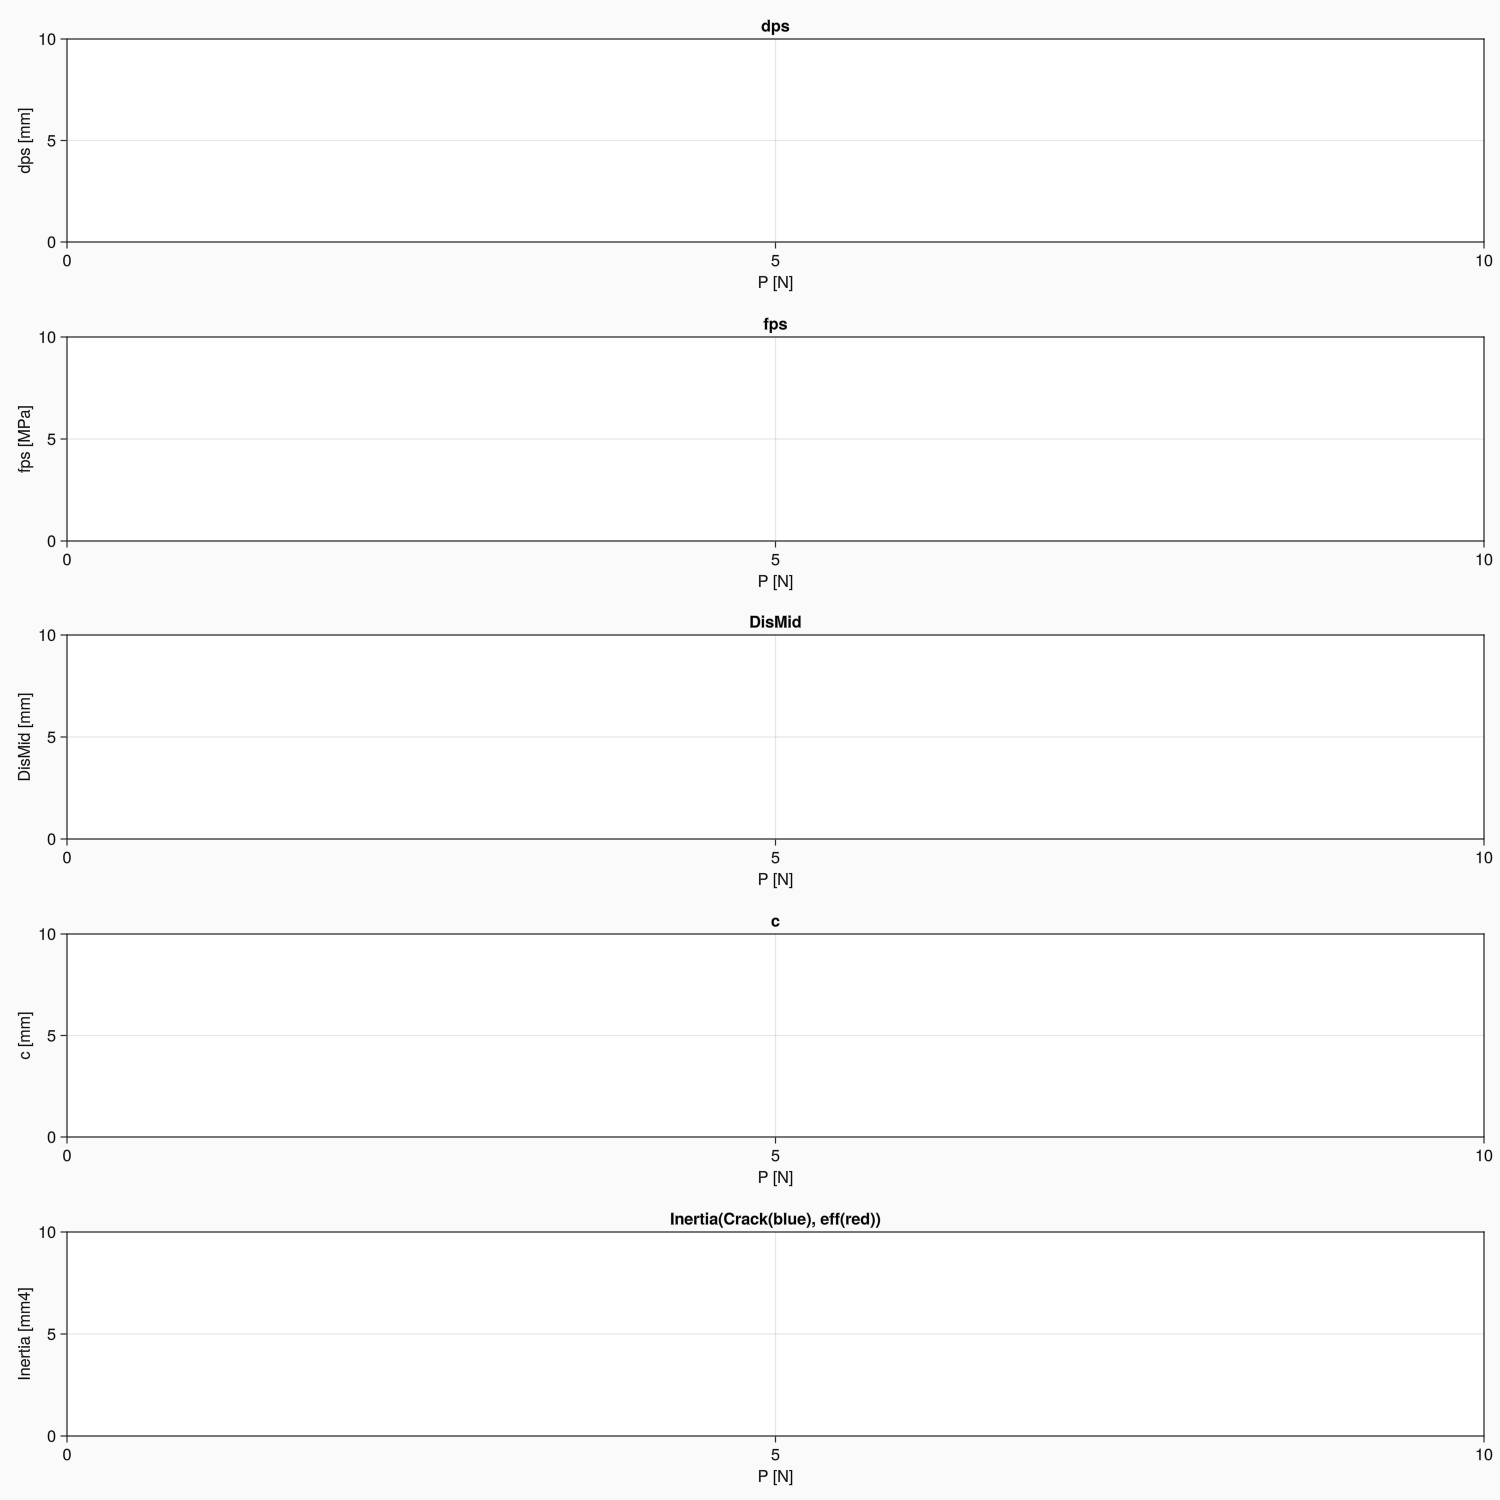

In [38]:
fig1

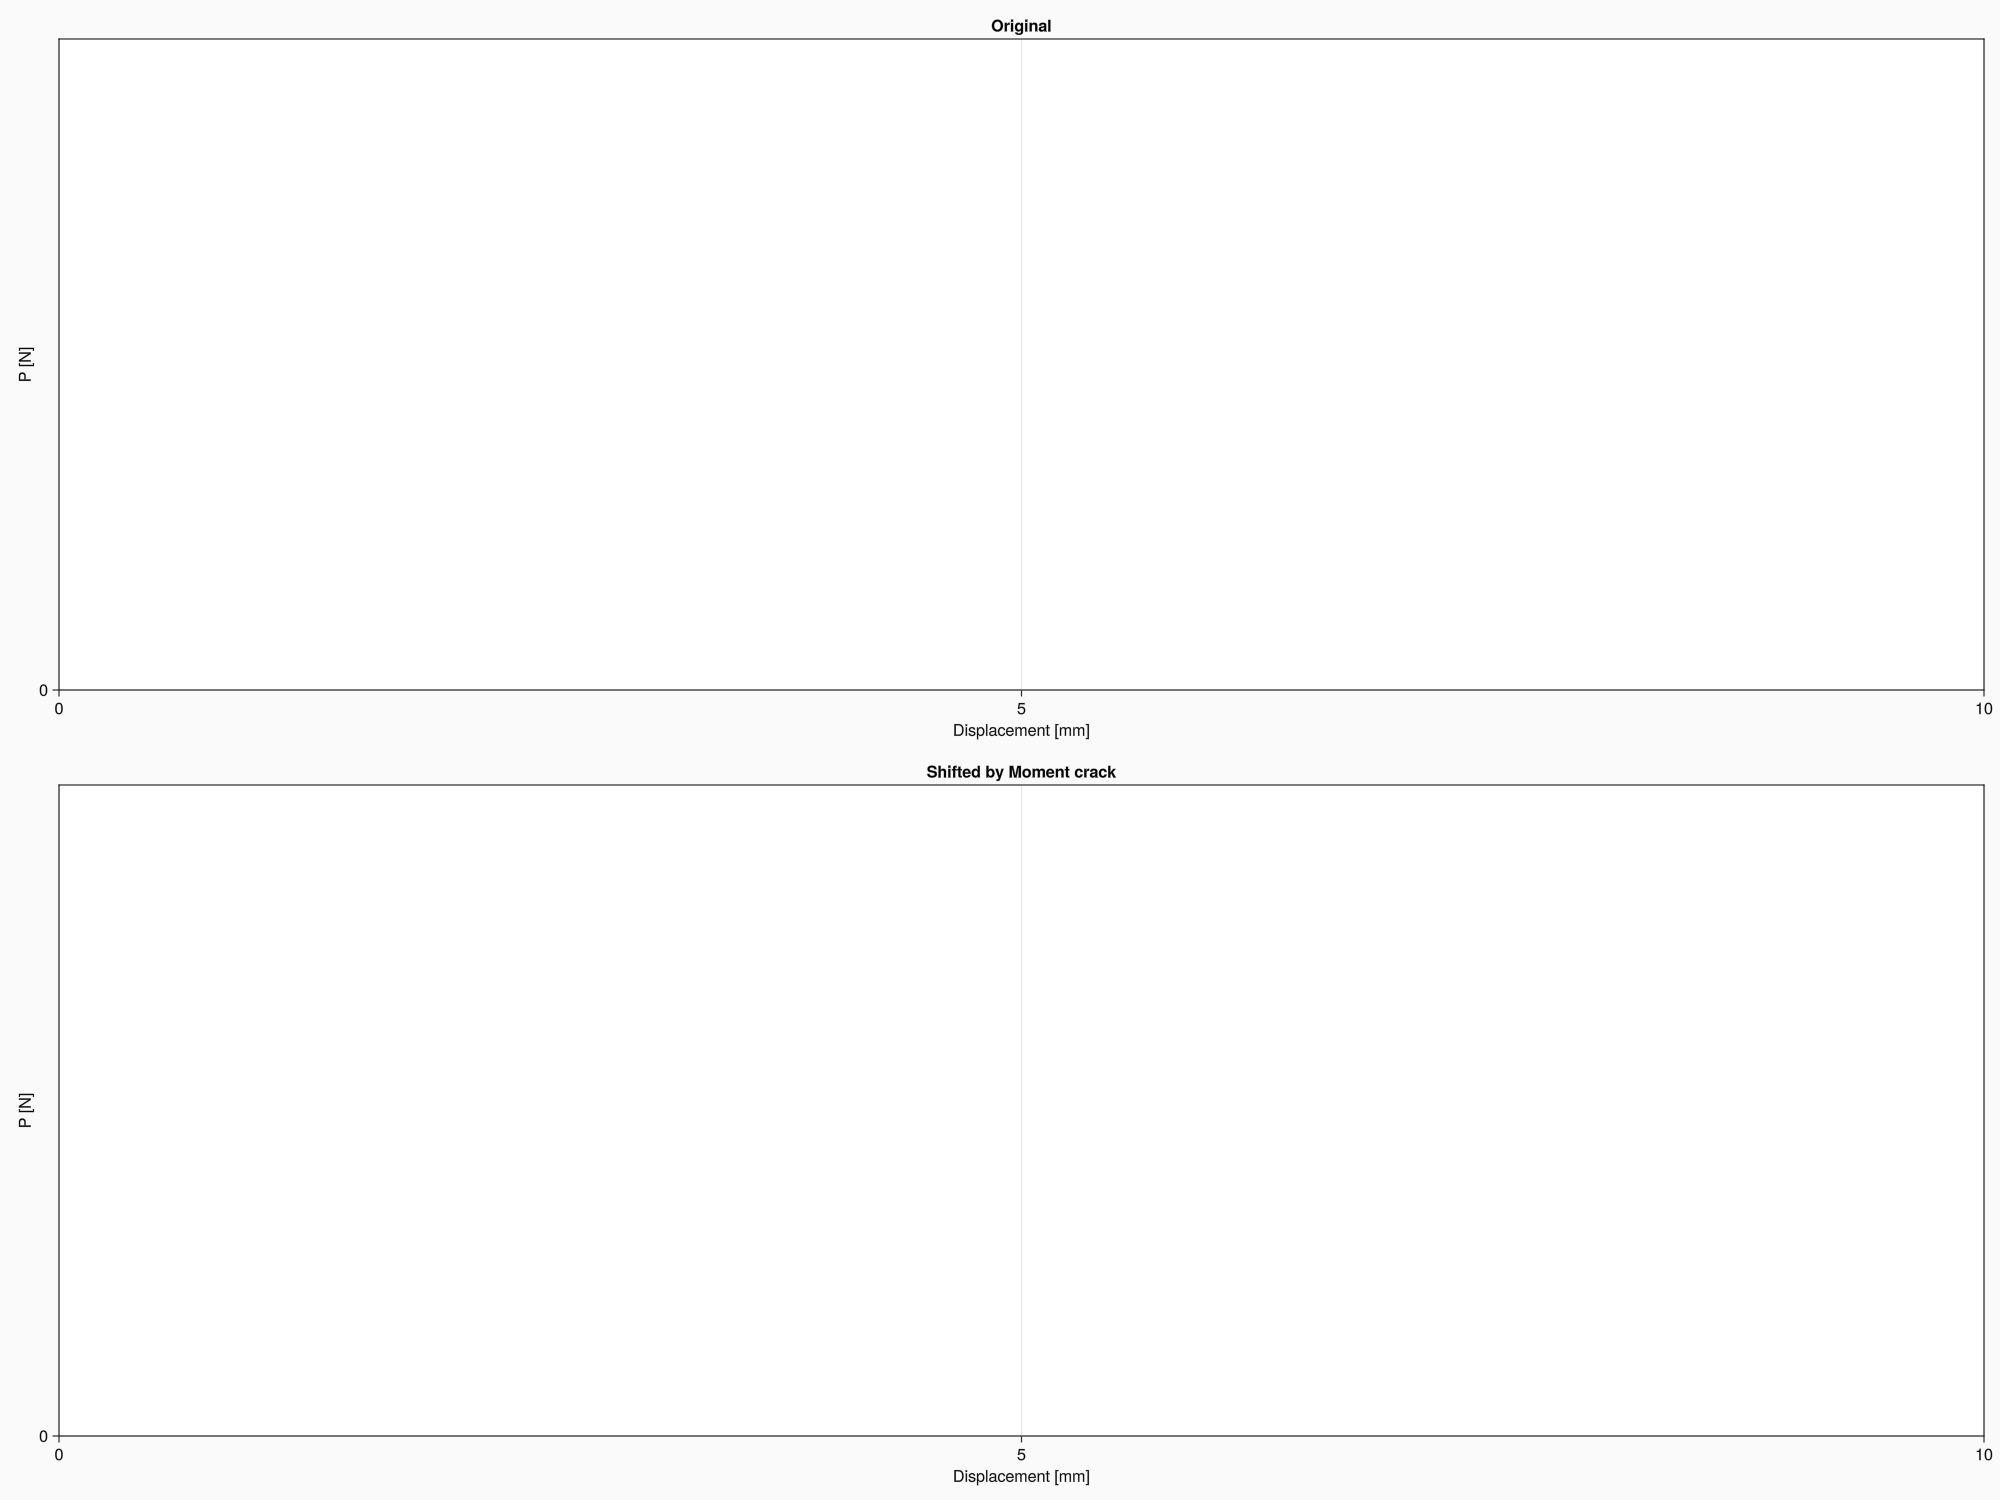

In [39]:
fig2

Setup output containers

In [40]:
lenP = length(P)
fps_history     = zeros(lenP)
dps_history     = zeros(lenP)
Icr_history     = zeros(lenP)
Ie_history      = zeros(lenP)
c_history       = zeros(lenP)
dis_history     = zeros(lenP)
dis_dev_history = zeros(lenP)
fc_history      = zeros(lenP)

831-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Following fig7 on the paper.

In [41]:
conv1 = 1
counter1 = 0
counter2 = 0
for i in eachindex(M)
    Mi = M[i] 
    Lc = getLc(Sec,Mcr,Mi)
    # Lc = L/2
    # println(Lc)
    # break
    counter1 = 0
    conv1 = 1
    while conv1 > 1e-6
        counter1 += 1 
        if counter1 > 1000
            println("Warning: 1st iteration did not converge")
            break
        end
        # println("HI")
        #assume value of Itr and fps

        conv2 = 1
        counter2 = 0
        while conv2 > 1e-6
            # println("counter")
            counter2 += 1 
            if counter2 > 1000
                println("Warning: 2nd iteration did not converge")
                break
            end
            Ωc = getΩc(Ω, Icr, Lc, Sec)
            # ps_force_i = Aps*fps

            c = 10.0 #dummy
            conv_c = 1 
            counter_c = 0 
            while conv_c > 1e-6 
                counter_c += 1
                if counter_c > 1000
                    println("Warning: 3rd iteration did not converge")
                    break
                end
                #centroid of concrete area might not be at c/2
                Ac_req = Mi/(dps-c/2)/(0.85*fc′)
            
                # Ac_req = ps_force_i /0.85/fc′
                new_c = get_C(Ac_req)
                conv_c = abs(new_c - c)/new_c
                c = new_c
            end
            #calculate Icr
            Icr_calc = get_Icrack(c)

            conv2 = abs(Icr_calc - Icr)/Icr_calc

            Icr = Icr_calc
            
        end
       
        # println("Icr = ", Icr)
        # println("Ac_req ", Ac_req)
        # println("c: ", c)
        # @show Mcr , Mdec, Mi , Icr, Itr
        Ie = getIe(Mcr, Mdec, Mi, Icr, Itr)
        # println("Ie/Icr" , Ie/Icr)
        δ_mid, δ_dev , e  = getDelta(Mat, Sec, f, Ie, Mi, em,fps)
        dps = dps0 - (δ_mid - δ_dev)
        fc = fps/Eps*c/(dps-c) + Mi/Itr*c
        # println("fc: ", fc)
        # @assert fc <= 0.003
        fps_calc = getFps2(Mat, Sec, f , Ωc, c, dps, fc)
        conv1 = abs(fps_calc - fps) / fps
        fps = fps_calc
        #plot convergence of fps, icr and dps using Makie

    end

    # δmid = getDeltamid()
    #record the history
    fps_history[i] = fps
    dps_history[i] = dps
    Icr_history[i] = Icr
    Ie_history[i]  = Ie
    c_history[i]   = c
    dis_history[i] = δ_mid
    fc_history[i]  = fc
    dis_dev_history[i] = δ_dev
end


Plot the results

In [42]:
scatter!(axis_monitor1[1], P, dps_history, color = :red)
scatter!(axis_monitor1[2], P, fps_history, color = :red)
# scatter!(axis_monitor1[2], P, fc_history, color = :blue)
scatter!(axis_monitor1[3], P, dis_history, color = :red)
# scatter!(axis_monitor1[3], P, dis_dev_history, color = :blue)
scatter!(axis_monitor1[4], P, c_history, color = :red)
scatter!(axis_monitor1[5], P, Ie_history, color = :red ,label = "Ie")
scatter!(axis_monitor1[5], P, Icr_history, color = :blue, label= "Icr")
#add verticle line on each plot for Mcr
for i in 1:5
    vlines!(axis_monitor1[i], [Mcr*2/Ls], color = :black, label = "Mcr", linewidth = 5)
    #add verticle line for Mdec
    vlines!(axis_monitor1[i], [Mdec*2/Ls], color = :green, label = "Mdec")

end

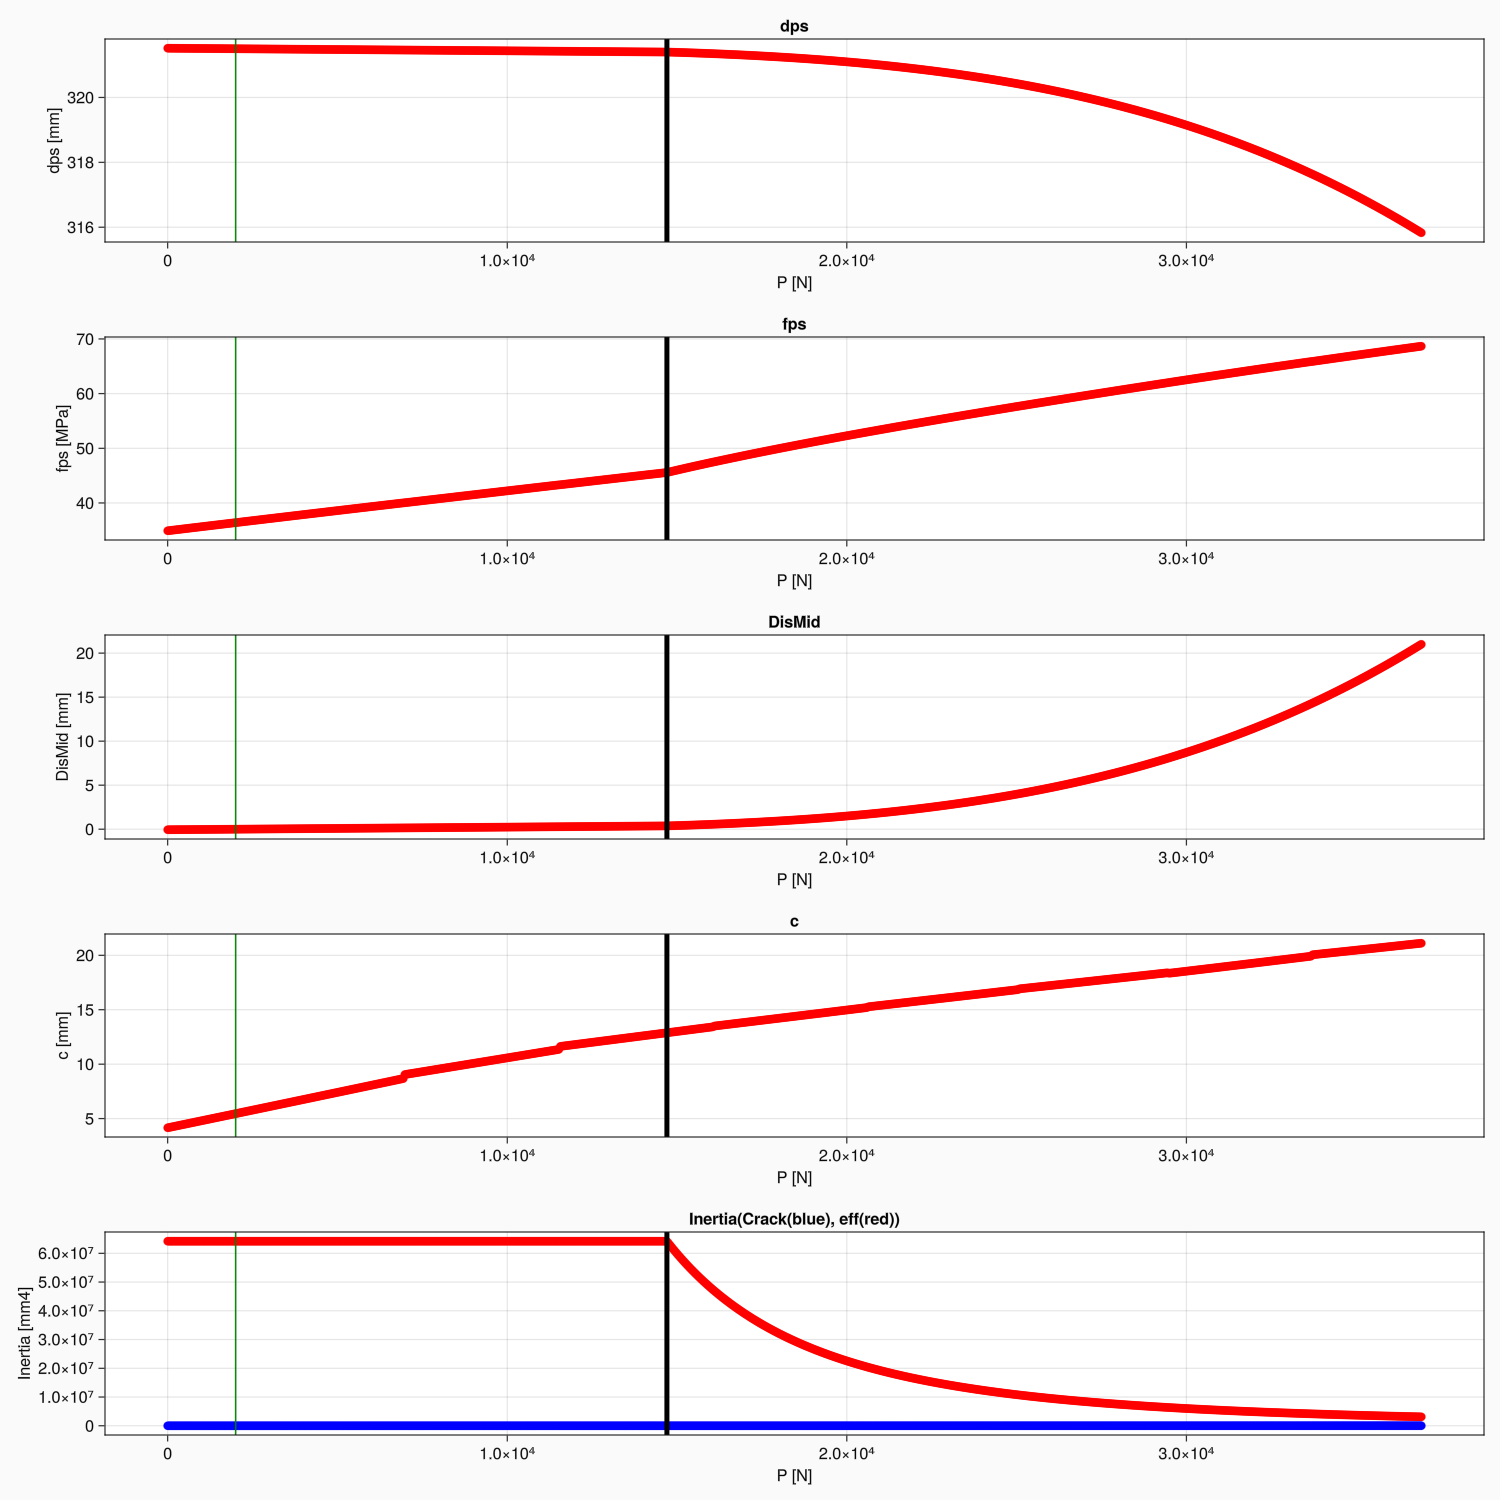

In [43]:
fig1

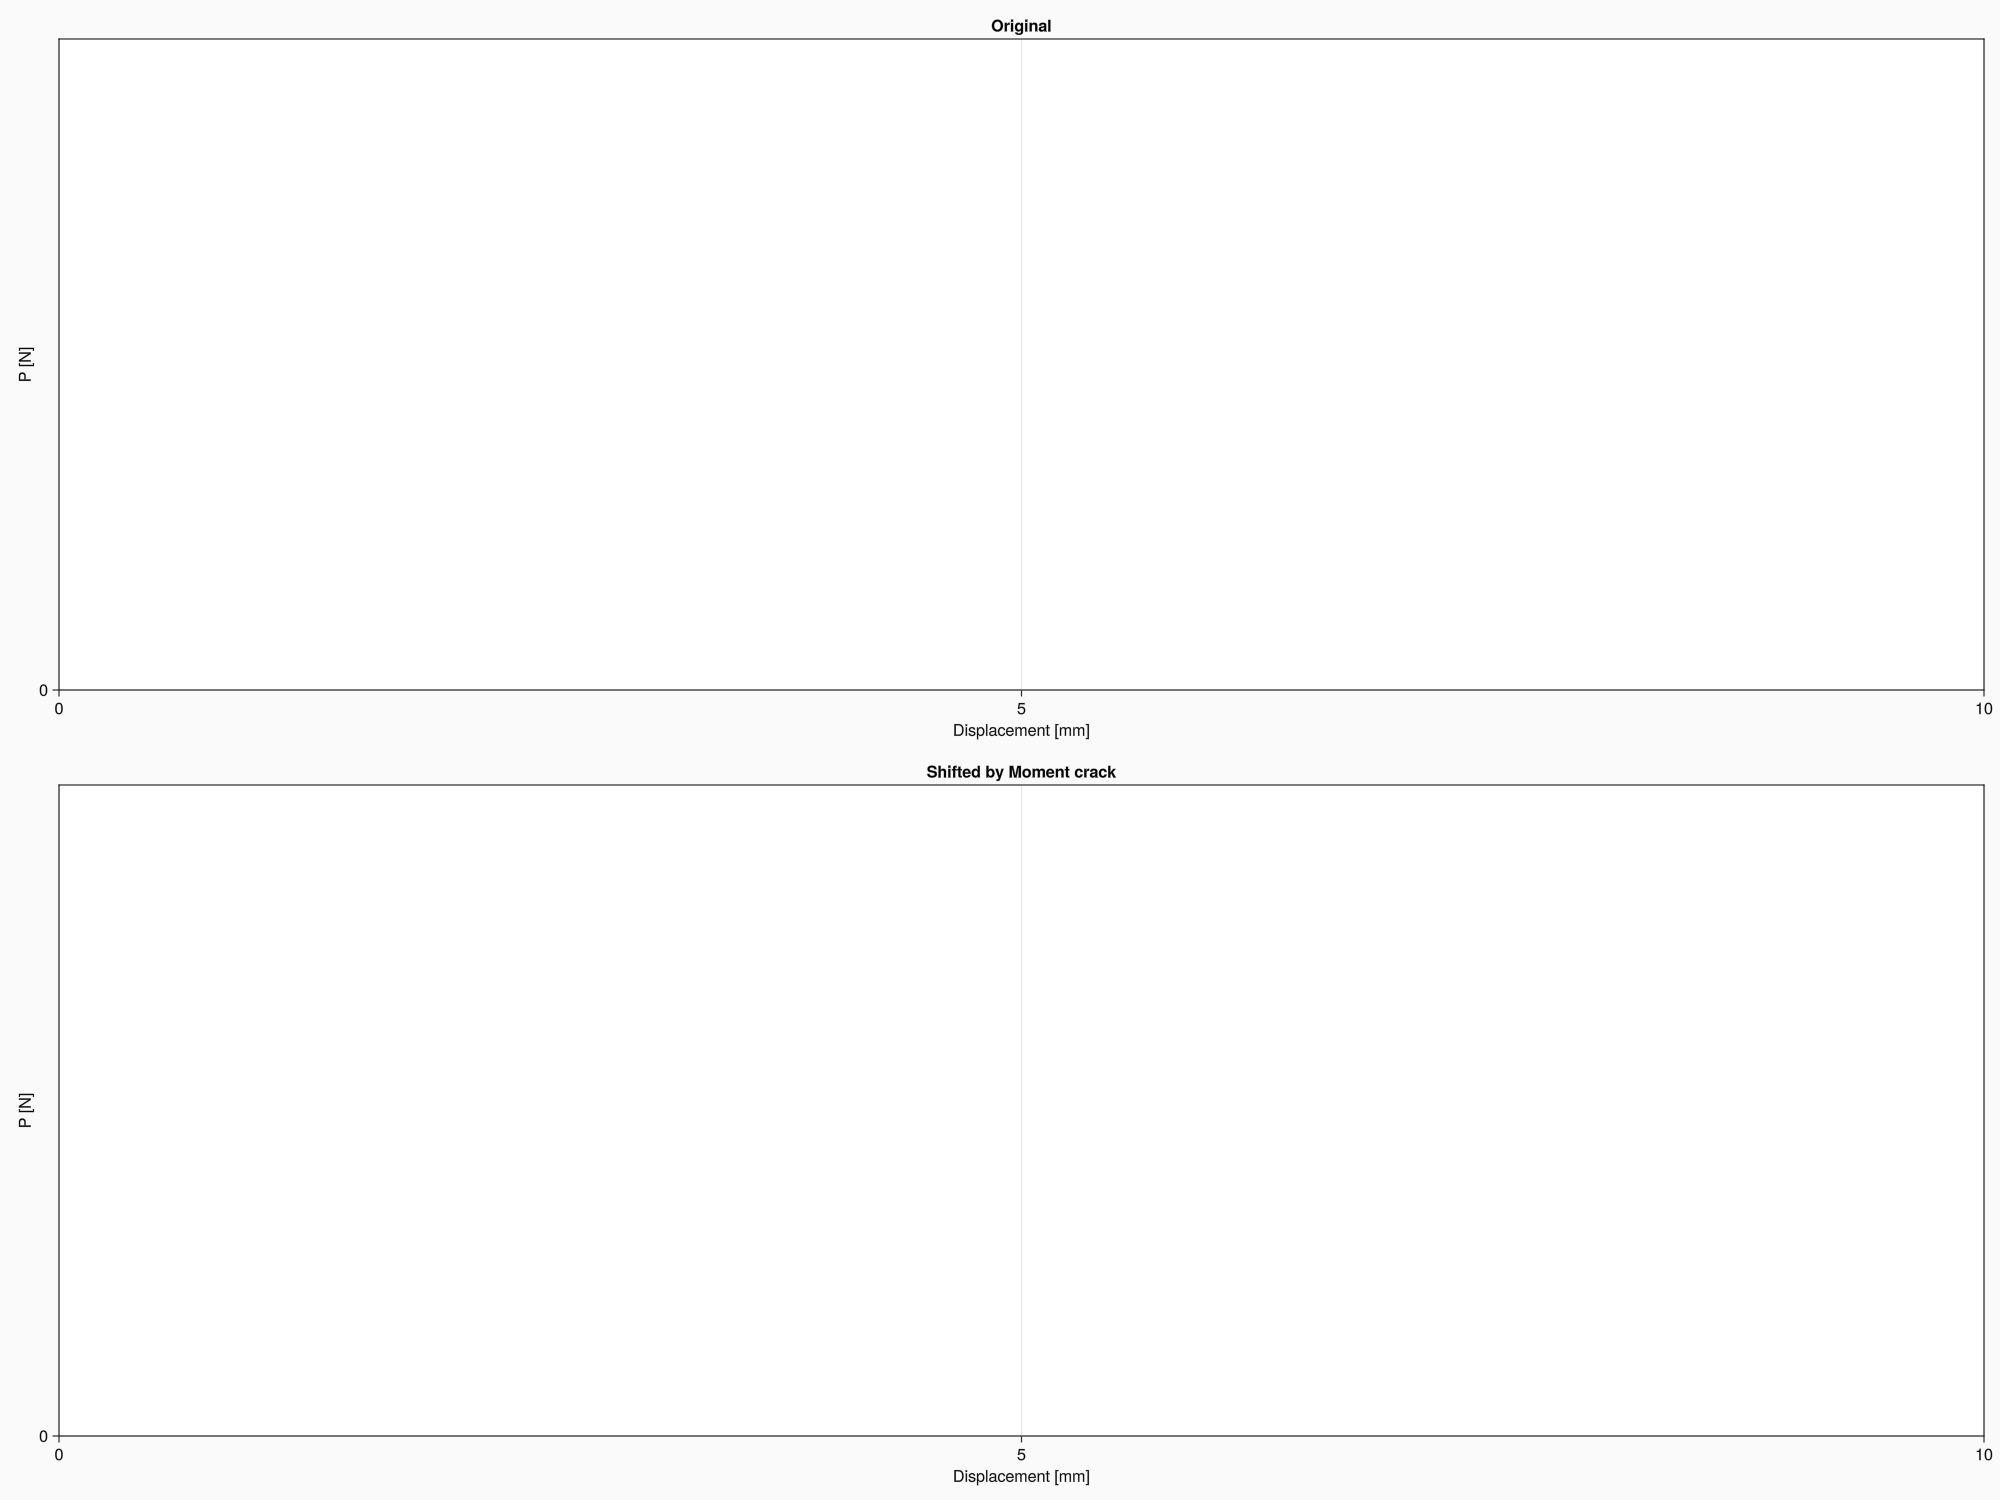

In [44]:
fig2

Load the test dataset to be compared with

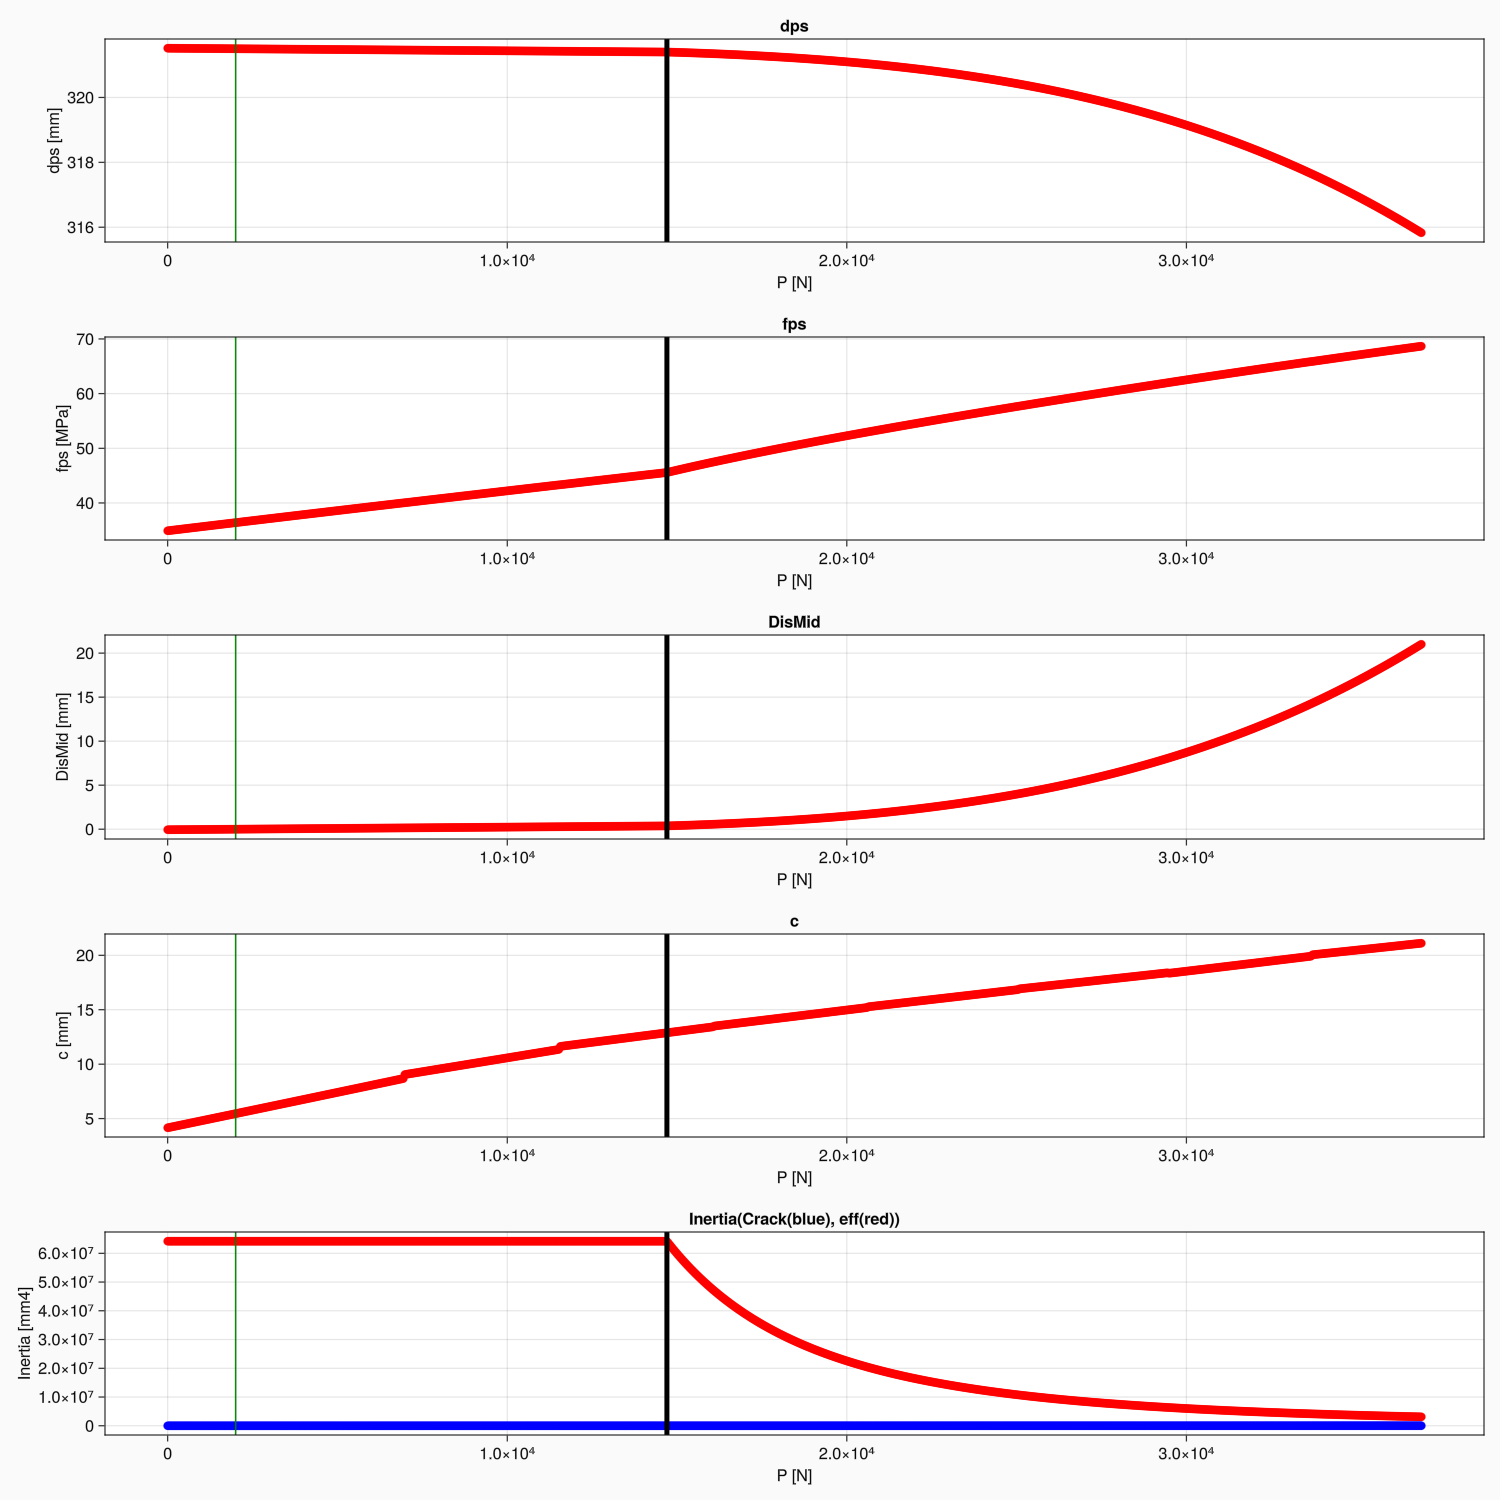

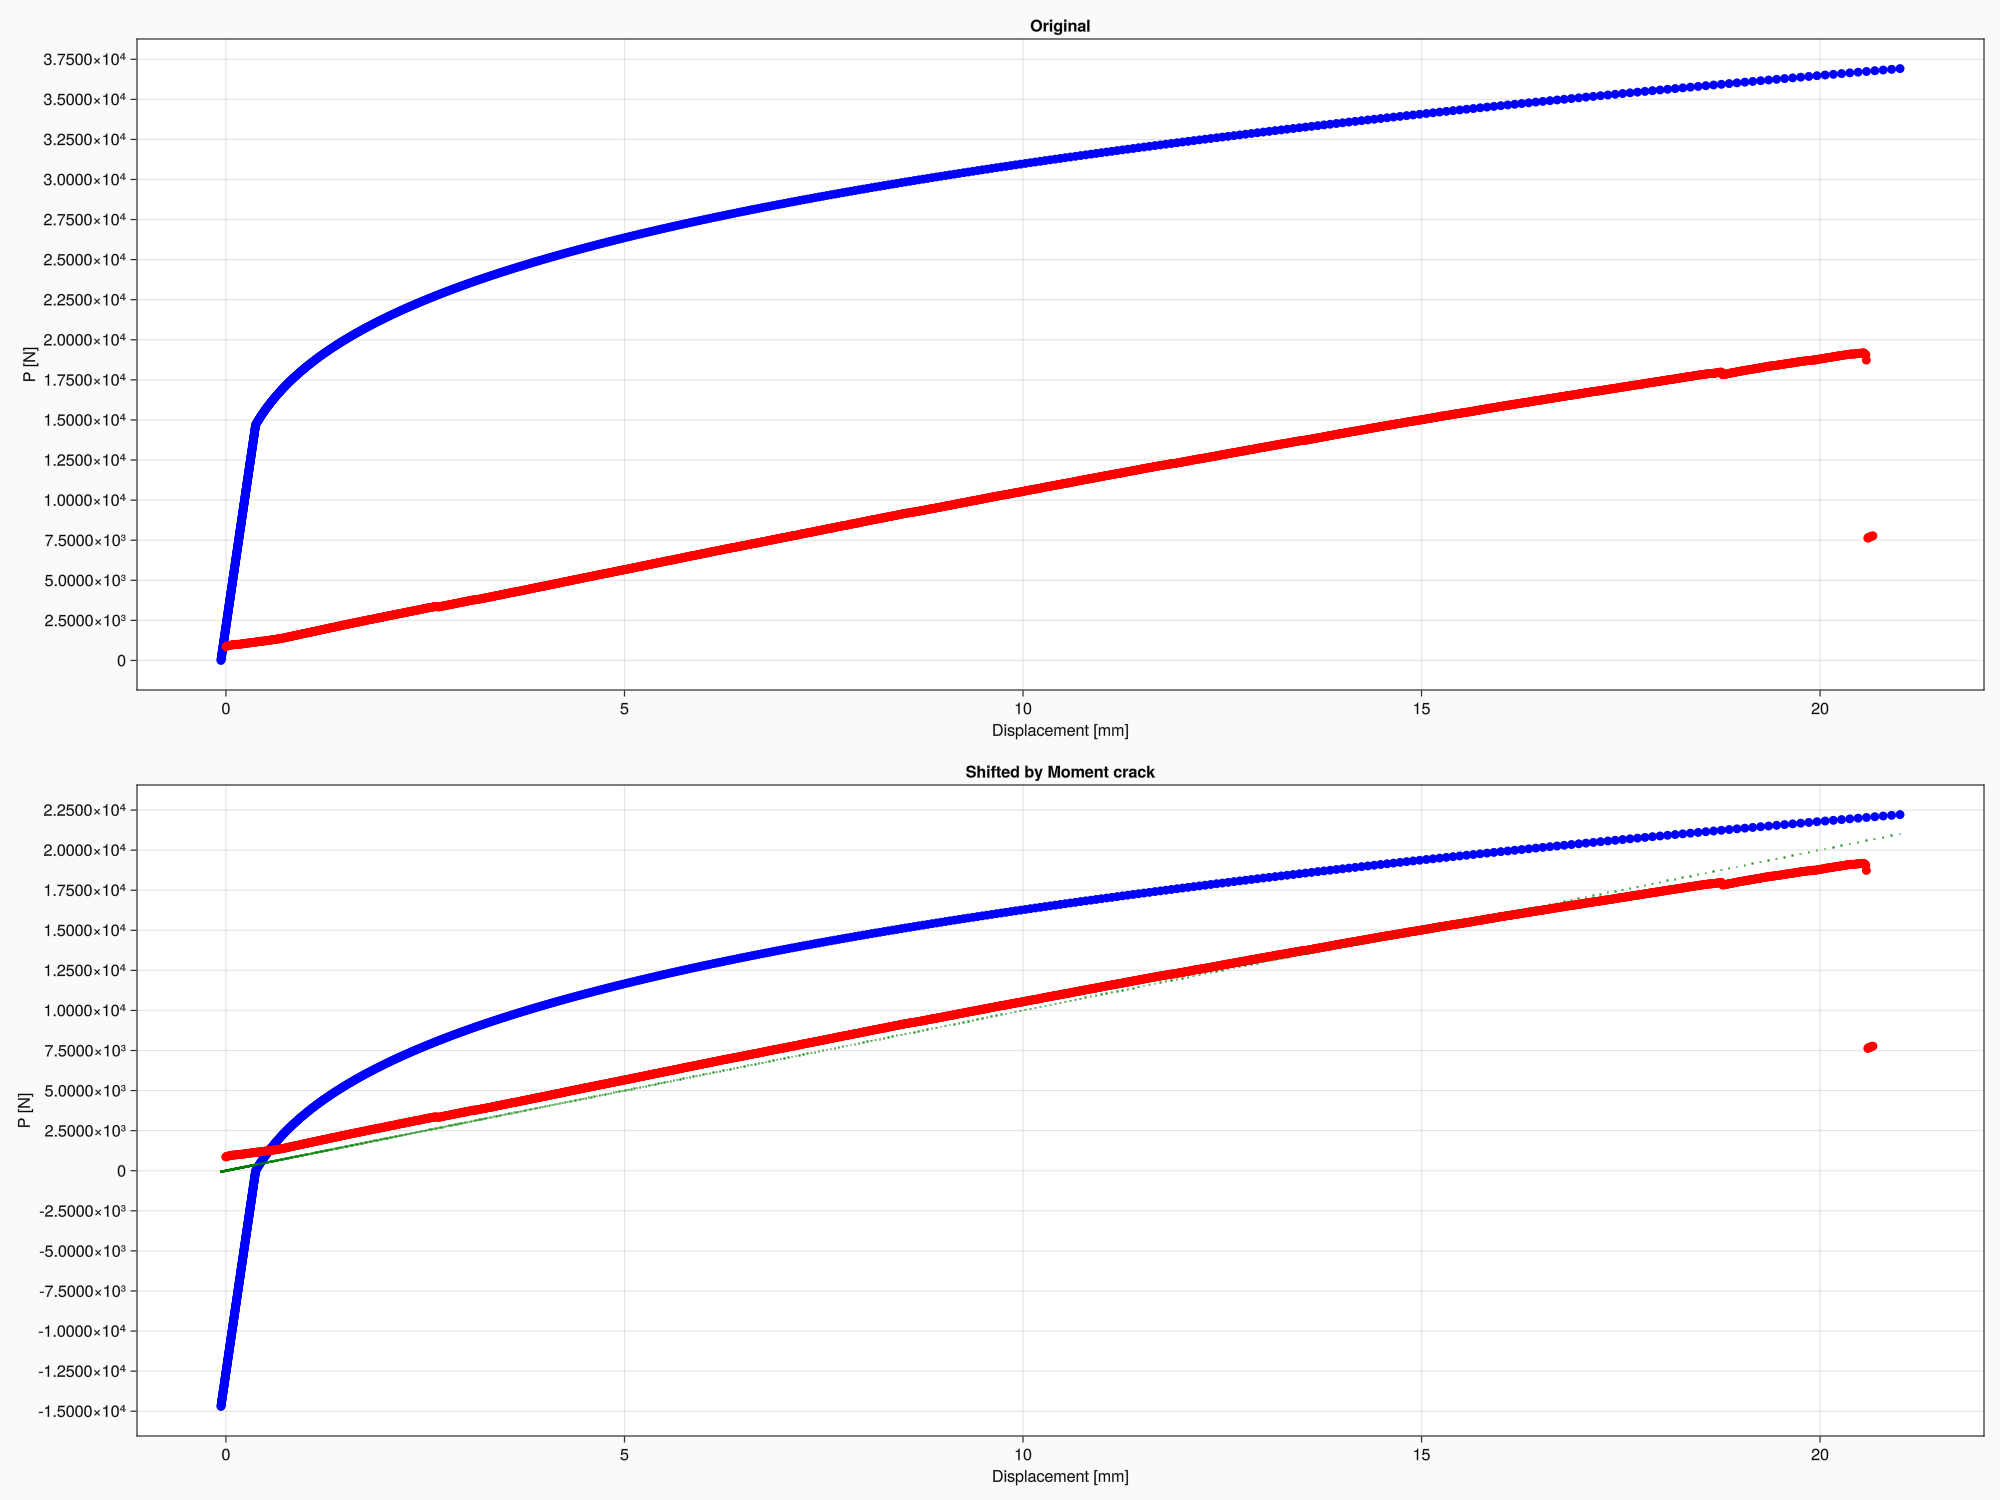

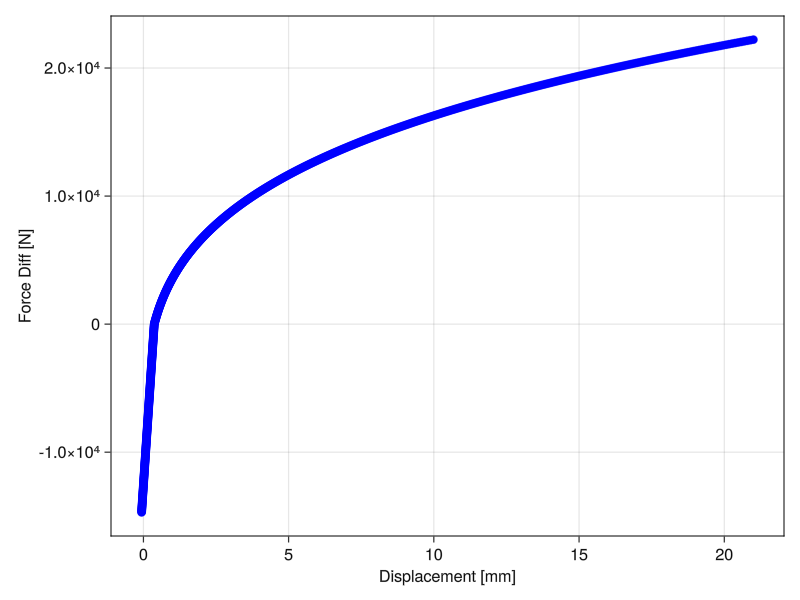

GLMakie.Screen(...)

In [46]:
df = CSV.File(joinpath(@__DIR__,"pixelframe_beam1.csv"))
df = DataFrame(df)
test_P = df[!,2]
test_d = df[!,3]

# convert to in to mm
test_d = test_d .* 25.4

test_P = test_P .* 4.44822

# figure2 = Figure(resolution = (800, 600))
# ax1 = Axis(figure2[1, 1], ylabel = "Load [lb]", xlabel = "Displacement [in]")
# ax2 = Axis(figure2[2, 1], ylabel = "fps[MPa]", xlabel = "Displacement [in]")

plot!(axis_monitor2[1],dis_history[1:end],P[1:end], label = "calc", color = :blue)
plot!(axis_monitor2[1],test_d,test_P, label = "test", color = :red)

plot!(axis_monitor2[2],dis_history[1:end],P[1:end].-Mcr*2/Ls, label = "calc", color = :blue)
plot!(axis_monitor2[2],test_d,test_P, label = "test", color = :red)
# display(fig_monitor)


fig3 = Figure(resolution = (800, 600))
ax3 = Axis(fig3[1, 1], ylabel = "Force Diff [N]", xlabel = "Displacement [mm]")
plot!(ax3,dis_history[1:end],P[1:end].-Mcr*2/Ls, label = "calc", color = :blue)
plot!(axis_monitor2[2], dis_history, dis_history.*1000, label = "dis/1000", color = :green, markersize = 1)
#plot 


display(fig1)
display(fig2)
display(fig3)